In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
df=pd.read_csv("../data/online_retail.csv",encoding="ISO-8859-1")

In [ ]:
df.shape
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [ ]:
df = df[df["CustomerID"].notna()]

In [9]:
df = df[~df["InvoiceNo"].str.startswith("C")]
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


In [ ]:
df.info()
df.shape

<class 'pandas.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  str           
 1   StockCode    397884 non-null  str           
 2   Description  397884 non-null  str           
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[us]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  str           
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[us](1), float64(3), int64(1), str(4)
memory usage: 30.4 MB


(397884, 9)

In [10]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

In [ ]:
rfm = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (snapshot_date - x.max()).days,"InvoiceNo": "nunique","TotalPrice": "sum"})


In [12]:
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)


In [13]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [14]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(
    rfm_scaled_array,
    index=rfm.index,
    columns=rfm.columns
)


In [16]:
rfm_scaled.describe()

,Recency,Frequency,Monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,2.702618e-17,1.801745e-17,1.801745e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.153401e-01,-4.250965e-01,-2.281344e-01
25%,-7.453445e-01,-4.250965e-01,-1.943495e-01
50%,-4.153533e-01,-2.951776e-01,-1.535104e-01
75%,4.946227e-01,9.457903e-02,-4.367134e-02
max,2.814561e+00,2.659803e+01,3.094634e+01


In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = clusters
rfm['Cluster'].value_counts()


Cluster
0    3231
1    1093
2      14
Name: count, dtype: int64

In [18]:
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)


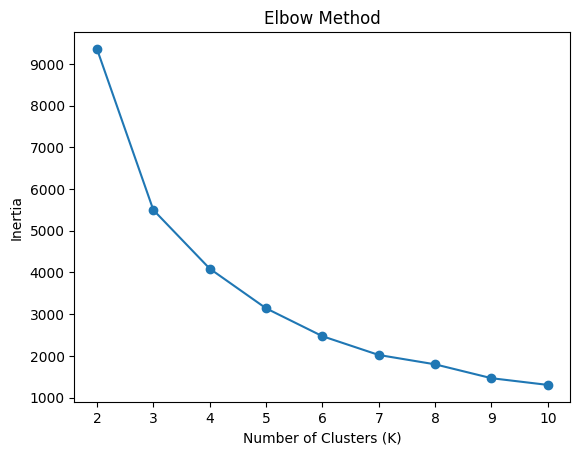

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [19]:
# k==4
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'] = clusters
rfm['Cluster'].value_counts()
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)


In [24]:
rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1359.049284
1,248.075914,1.552015,480.617480
2,7.384615,82.538462,127338.313846
3,15.500000,22.333333,12709.090490


In [ ]:
import pandas as pd

segment_map = {
    0: "Regular Customers",
    1: "Lost Customers",
    2: "VIP_Whales",
    3: "Loyal Customers"
}

rfm["Segment"] = rfm["Cluster"].map(segment_map)

output_file = "RFM_Customer_Segments.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for cluster_id, segment_name in segment_map.items():
        df_segment = rfm[rfm["Cluster"] == cluster_id]
        df_segment.to_excel(writer, sheet_name=segment_name, index=False)

print("Excel file created with 4 sheets.")


Exception ignored in: <function ZipFile.__del__ at 0x000002783F81C0E0>
Traceback (most recent call last):
  File "C:\Python312\Lib\zipfile\__init__.py", line 1940, in __del__
    self.close()
  File "C:\Python312\Lib\zipfile\__init__.py", line 1957, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


Excel file created with 4 sheets.


In [33]:
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,326,1,77183.60,3,Loyal Customers
12347.0,2,7,4310.00,0,Regular Customers
12348.0,75,4,1797.24,0,Regular Customers
12349.0,19,1,1757.55,0,Regular Customers
12350.0,310,1,334.40,1,Lost Customers
